# Calculate and plot meridional heat transport

## Uses two methods because of diagnostics available:
- From surface heat flux assuming steady state
- From temp_yflux_adv diagnostic (so does not include submeso or gm/diffusion if they are on)

In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import numpy as np
import pandas as pd
import IPython.display
import cmocean as c
from dask.distributed import Client


import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))  # so we can import ../exptdata
import exptdata

print('Available exptdata keys: ', [k for k in exptdata.exptdict.keys()])

netcdf_index loaded.


/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/g/data3/hh5/public/apps/miniconda3/envs/analysis3-19.01/lib/python3.6/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


Available exptdata keys:  ['1deg', '025deg', '01deg']


In [2]:
# Set 1-degree data to be different for MHT diagnostics:
exptdata.exptdict['1deg']['exptdir'] = '/g/data3/hh5/tmp/cosima/access-om2/1deg_jra55v13_iaf_spinup1_B1_lastcycle'
exptdata.exptdict['1deg']['expt'] = '1deg_jra55v13_iaf_spinup1_B1_lastcycle'

tstart = exptdata.clim_tstart
tend = exptdata.clim_tend

In [3]:
figdir = ''
def savefigure(fname):
    plt.savefig(os.path.join(figdir, fname+'.png'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    plt.savefig(os.path.join(figdir, fname+'.pdf'),dpi=300, bbox_inches="tight")  # comment out to disable saving
    return

In [4]:
#cc.start_cluster()
client = Client('tcp://10.0.64.18:8786', local_dir='/local/g40/amh157')
client

OSError: Timed out trying to connect to 'tcp://10.0.64.18:8786' after 3 s: connect() didn't finish in time

In [6]:
# use int_z MHT diagnostics:
def find_MHF_intz(ekey):
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    # n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    temp_yflux_adv = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_adv_int_z',
                                        n=n_files, time_units = time_units, offset=offset, use_cache=False)
    temp_yflux_submeso = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_submeso_int_z',
                                            n=n_files, time_units = time_units, offset=offset)
    MHF = (temp_yflux_adv.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')+temp_yflux_submeso.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()
    if (ekey != '01deg'):
        temp_yflux_gm = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_gm_int_z',
                                           n=n_files, time_units = time_units, offset=offset)
        temp_yflux_ndiffuse = cc.get_nc_variable(expt, 'ocean_month.nc', 'temp_yflux_ndiffuse_int_z',
                                           n=n_files, time_units = time_units, offset=offset)
        MHF = MHF + (temp_yflux_gm.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')+temp_yflux_ndiffuse.sel(time=slice(tstart,tend)).mean('time').sum('xt_ocean')).load()

    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yu_ocean',n=1).load()
    return latv, MHF

(-2, 2.5)

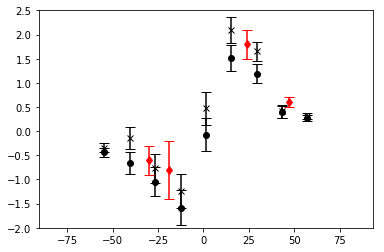

In [15]:
# Read in observed meridional heat transport from Trenberth and Caron (http://www.cgd.ucar.edu/cas/catalog/ocean/ohts/rean_ohts.html)
df=pd.read_csv('ANNUAL_TRANSPORTS_1985_1989.ascii.txt', sep=' ',skiprows=1,skipinitialspace=True)
obs_lat = df.values[:,0]/100.
obs_ncep = df.values[:,6]/100.
obs_ncep_er = df.values[:,10]/100
obs_ecmwf = df.values[:,14]/100.
obs_ecmwf_er = df.values[:,18]/100.
plt.errorbar(obs_lat[::5],obs_ncep[::5],yerr=obs_ncep_er[::5],fmt='xk',capsize=5)
plt.errorbar(obs_lat[::5],obs_ecmwf[::5],yerr=obs_ecmwf_er[::5],fmt='ok',capsize=5)
plt.ylim([-2, 2.5])

# Read in observed MHT from Ganachaud and Wunsch 2000 (
df=pd.read_csv('GW2003_GlobalMHT.txt', sep=' ',skiprows=0,skipinitialspace=True)
obsGW2003_lat = df.values[:,0]
obsGW2003_mht = df.values[:,1]
obsGW2003_mhte = df.values[:,2]
plt.errorbar(obsGW2003_lat,obsGW2003_mht,yerr=obsGW2003_mhte,fmt='dr',capsize=5)
plt.ylim([-2, 2.5])

NameError: name 'find_MHF_intz' is not defined

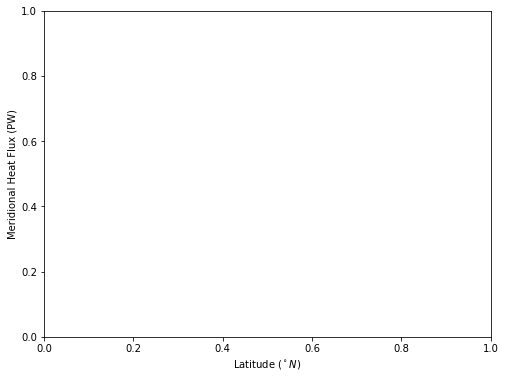

In [28]:
# plot both surface heat flux, temp_yflux_adv methods and observations:
fig = plt.figure(figsize=(8,6))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF_intz(ekey)

    hand = plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.plot(obs_lat,obs_ncep,'xk',label='NCEP', markersize=6)
plt.errorbar(obs_lat[3::5],obs_ncep[3::5],yerr=obs_ncep_er[3::5],fmt='xk',capsize=3)
plt.plot(obs_lat,obs_ecmwf,'ok',label='ECMWF', markersize=3)
plt.errorbar(obs_lat[::5],obs_ecmwf[::5],yerr=obs_ecmwf_er[::5],fmt='ok',capsize=3)
plt.errorbar(obsGW2003_lat,obsGW2003_mht,yerr=obsGW2003_mhte,fmt='dr',capsize=8,label='GW2003')
plt.plot([-90, 90],[0,0],'k-',linewidth=0.75)
plt.legend(loc=2)
plt.xlim([-90.,90.])
plt.ylim([-2, 2.5])

savefigure('meridional_heat_transport_intz_withobs')

In [8]:
cc.get_ncfiles(exptdata.exptdict['1deg']['expt'])

['iceh.\\d+-\\d+.nc',
 'o2i.nc',
 'ocean_month.nc',
 'ocean.nc',
 'ocean_grid.nc',
 'ocean_scalar.nc',
 'ocean_snapshot.nc',
 'ocean_daily.nc']

In [18]:
cc.get_variables(exptdata.exptdict['1deg']['expt'],'ocean_month.nc')

['xu_ocean',
 'yu_ocean',
 'st_ocean',
 'st_edges_ocean',
 'time',
 'nv',
 'xt_ocean',
 'yt_ocean',
 'u',
 'v',
 'temp',
 'pot_temp',
 'salt',
 'temp_vdiffuse_impl',
 'temp_tendency',
 'temp_tendency_expl',
 'temp_submeso',
 'temp_advection',
 'temp_nonlocal_KPP',
 'temp_eta_smooth',
 'neutral_gm_temp',
 'neutral_diffusion_temp',
 'temp_vdiffuse_diff_cbt',
 'temp_vdiffuse_diff_cbt_conv',
 'temp_vdiffuse_k33',
 'temp_vdiffuse_sbc',
 'temp_rivermix',
 'temp_sigma_diff',
 'mixdownslope_temp',
 'sea_level',
 'eta_t',
 'sea_levelsq',
 'mld',
 'surface_temp',
 'surface_salt',
 'pme_river',
 'river',
 'runoff',
 'evap',
 'melt',
 'sfc_salt_flux_restore',
 'sfc_salt_flux_ice',
 'sfc_salt_flux_coupler',
 'net_sfc_heating',
 'tau_x',
 'tau_y',
 'bmf_u',
 'bmf_v',
 'tx_trans_int_z',
 'ty_trans_int_z',
 'aredi',
 'agm',
 'frazil_3d',
 'swflx',
 'sw_heat',
 'sfc_hflux_from_runoff',
 'sfc_hflux_coupler',
 'sfc_hflux_pme',
 'temp_yflux_adv_int_z',
 'temp_yflux_submeso_int_z',
 'temp_yflux_ndiffuse_in

In [ ]:
# Infer from surface heat flux:
def find_MHF(ekey):
    
    expt = exptdata.exptdict[ekey]['expt']
    n_files = exptdata.exptdict[ekey]['n_files']
    #n_files = 1
    time_units = exptdata.exptdict[ekey]['time_units']
    offset = exptdata.exptdict[ekey]['offset']

    shflux = cc.get_nc_variable(expt, 'ocean_month.nc', 'net_sfc_heating',
                          n=n_files, time_units = time_units, offset=offset, use_cache=True)
    shflux_am = shflux.mean('time').load()
    area = cc.get_nc_variable(expt, 'ocean_grid.nc','area_t',n=1).load()
    lat = cc.get_nc_variable(expt, 'ocean_grid.nc','geolat_t',n=1).load()
    latv = cc.get_nc_variable(expt, 'ocean_grid.nc','yt_ocean',n=1).load()
    MHF = np.zeros_like(latv)
    for i in range(len(latv)):
        inds = lat < latv[i]
        MHF[i] = np.sum(area.where(lat < latv[i])*shflux_am.where(lat < latv[i]))

    MHF = MHF + (MHF[0]-MHF[-1])/2
    
    return latv, MHF

In [ ]:
# Plot just surface heat flux inferred method:
fig = plt.figure(figsize=(8,5))
plt.xlabel('Latitude $(^\circ N)$')
plt.ylabel('Meridional Heat Flux (PW)')
for i, ekey in enumerate(exptdata.exptdict.keys()):
    latv, MHF = find_MHF(ekey)

    plt.plot(latv,MHF/1.e15,linewidth=2, label=exptdata.exptdict[ekey]['desc'])

plt.legend()
savefigure('meridional_heat_transport')